# Eisamay property log analysis

> **The aim of this analysis is to identify and correct the various types of errors which reach our vm machines and aim to fix them. By analysing the logs and identifying where we are facing the errors we can:**
* improve our websites response rate 
* reduce bounce rate.
* Identify key sources of errors
* Identify key problems within our code base which would be applicable across properties
* Identify platform / property / VM  specific errors 


In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [230]:
# Reading the log file
df = pd.read_csv('combined_error_log.csv',index_col=False)

In [231]:
# Seeing data
df.head(5)

,IP,TIME,PLATFORM,REQ_URL,REQ_FEED,DESC
0,172.29.63.76,17-12-2020 0:0:5,desktop,https://eisamay.indiatimes.com/entertainment/cinema/articlelist/51012377.cms,https://eisamay.indiatimes.com/pwafeeds/sc_gadgetlist.cms?category=mobile&feedtype=sjson&pagetype=widget&perpage=10&sort=latest,Error: Request failed with status code 404
1,172.29.63.76,17-12-2020 0:0:7,desktop,https://eisamay.indiatimes.com/entertainment/cinema/articlelist/51012377.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat ServerResponse.setHeader (_http_outgoing.js:481:11)at y (/opt/deployment/production/eisweb_63/dist/server.js:1:1085991)at Object.<anonymous> (/opt/deployment/production/eisweb_63/dist/server.js:1:1090471)at tryCatch (/opt/deployment/production/eisweb_63/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/eisweb_63/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/eisweb_63/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/eisweb_63/dist/server.js:1:1080407)at /opt/deployment/production/eisweb_63/dist/server.js:1:1080553at new Promise (/opt/deployment/production/eisweb_63/node_modules/core-js/modules/es6.promise.js:177:7)at /opt/deployment/production/eisweb_63/dist/server.js:1:1080351'
2,172.29.63.76,17-12-2020 0:0:8,mobile,https://eisamay.indiatimes.com/west-bengal-news/24pargana-news/articlelist/49780592.cms,https://eisamay.indiatimes.com/pwafeeds/sc_gadgetlist.cms?category=mobile&feedtype=sjson&pagetype=widget&perpage=10&sort=latest,Error: Request failed with status code 404
3,172.29.63.76,17-12-2020 0:0:14,mobile,https://eisamay.indiatimes.com/bangla-news-live/-/amp_articleshow/63640426.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/eismweb_79/dist/server.js:1:182185)at /opt/deployment/production/eismweb_79/dist/server.js:1:440852at O (/opt/deployment/production/eismweb_79/dist/server.js:1:441056)at e.t.render (/opt/deployment/production/eismweb_79/dist/server.js:1:450327)at e.t.read (/opt/deployment/production/eismweb_79/dist/server.js:1:449906)at renderToString (/opt/deployment/production/eismweb_79/dist/server.js:1:455097)at w (/opt/deployment/production/eismweb_79/dist/server.js:1:1243482)at Object.<anonymous> (/opt/deployment/production/eismweb_79/dist/server.js:1:1247299)at tryCatch (/opt/deployment/production/eismweb_79/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/eismweb_79/node_modules/regenerator-runtime/runtime.js:303:22)'
4,172.29.63.76,17-12-2020 0:0:16,desktop,https://eisamay.indiatimes.com/videos/entertainment/vidyas-kahaani-2-to-clash-with-srk-alias-dear-zindagi-now/videoshow/54488137.cms/feeds/vod_player.cms?autoplay=0&dim=0&msid=54488137&source=article&userInitiated=1&videosection=article-show,NaN,'TypeError: Cannot read property 'components' of undefinedat c (/opt/deployment/production/eisweb_63/dist/server.js:1:1081152)at /opt/deployment/production/eisweb_63/dist/server.js:1:1089765at /opt/deployment/production/eisweb_63/node_modules/react-router/lib/match.js:67:5at /opt/deployment/production/eisweb_63/node_modules/react-router/lib/createTransitionManager.js:72:11at next (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/AsyncUtils.js:52:7)at loopAsync (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/AsyncUtils.js:56:3)at matchRoutes (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/matchRoutes.js:245:29)at Object.match (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/createTransitionManager.js:66:33)at match (/opt/deployment/production/eisweb_63/node_modules/react-router/lib/match.js:56:21)at /opt/deployment/production/eisweb_63/dist/server.js:1:1089641'


> **Dropping any duplicate types of errors based on the following combination**



In [232]:
df.drop_duplicates(subset=['PLATFORM','REQ_URL', 'REQ_FEED','DESC'], keep='last')
df.shape

(55401, 6)

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55401 entries, 0 to 55400
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IP        55401 non-null  object
 1   TIME      55401 non-null  object
 2   PLATFORM  55401 non-null  object
 3   REQ_URL   55401 non-null  object
 4   REQ_FEED  27877 non-null  object
 5   DESC      55401 non-null  object
dtypes: object(6)
memory usage: 2.5+ MB


* **Parsing time and date to get a more accurate analysis if needed**

In [234]:
# Adding parsed time 
# df['TIME'] = df['TIME'].apply(lambda x: x.strip())
# df['PARSED_TIME'] =df['TIME'].apply(lambda x: x[11:].strip())
# df['PARSED_TIME'] = df['PARSED_TIME'].apply(lambda x: x[:x.rindex(':')])
# df['PARSED_DATE'] = df['TIME'].apply(lambda x: x[:11].strip())
# df['PARSED_TIME'].head(30)
# df['PARSED_TIME'] = pd.to_datetime(df['PARSED_TIME'], format='%H:%M')
# df['PARSED_TIME'].head(30)
## Parsing time and date, converting to datetime
df['PARSED_DATE_TIME'] = pd.to_datetime(df['TIME'], format='%d-%m-%Y %H:%M:%S')
df['PARSED_DATE_TIME'].dt.time.head()


hour_labels = [str(x) + '-'+str(x+1) for x in range(23)]
hour_labels.append('23-0')
hour_labels

## Binning the same to make it a categorical variable.
df["BINNED_HOURS"] = pd.cut(df.PARSED_DATE_TIME.dt.hour, bins=24,labels=hour_labels)
df['BINNED_HOURS']

0         0-1
1         0-1
2         0-1
3         0-1
4         0-1
         ... 
55396    23-0
55397    23-0
55398    23-0
55399    23-0
55400    23-0
Name: BINNED_HOURS, Length: 55401, dtype: category
Categories (24, object): [0-1 < 1-2 < 2-3 < 3-4 ... 20-21 < 21-22 < 22-23 < 23-0]

* **Categorizing urls based on page types**

In [235]:
def categorize_url(url):
    template_map = {
        'amp_':'amp',
        'articleshow':'articleshow',
        'photoshow':'photoshow',
        'photolist':'photolist',
        'videoshow':'videoshow',
        'articlelist':'articlelist',
        'topics':'topics'
    }
    for template in template_map:
        if template in url:
            return template_map[template]
    return 'others'
df['URL_CATEGORY'] = df['REQ_URL'].apply(categorize_url)


**Categorizing Errors based on Error types**

How i found the categories:
1. Initially i was assuming we generally face two types of errors: **404** for invalid feed hit, or **9000ms** where feed responds slowly. However inspecting and grouping feed errors
2. First inspected the df, found **404 and undefined**, started with these as a base along with **null**
3. Characterized others as **"others"** manually inspected others one by one and found: **410 ,403, ['object Object'] timeout and ECONNRESET**


In [236]:
# How i found the categories:
# First inspected the df, found 404 and undefined, started with these as a base along with null
# Characterized others as "others" manually inspected others one by one and
# found: 410 ,403, ['object Object'] timeout
def categorize_error(error):
    #     categories = ['null','undefined','404','410','ERR_HTTP_HEADERS_SENT','9000ms']
    categories = {
       '[object Object]':'[object Object]','undefined':'undefined','404':'404','410':'410','403':'403','ECONNRESET':'ECONNRESET','ERR_HTTP_HEADERS_SENT':'ERR_HTTP_HEADERS_SENT','9000ms':'timeout'       
    }
    for cat in categories:
        if cat in error:
            return categories[cat]
    return 'other'
            
df['ERROR_TYPE'] = df['DESC'].apply(categorize_error)

*  **Further inspection reveals that some urls are broken with '-' '/-' or '%' values in SEO in between. It will be useful if we categorize these.**

In [237]:
# Categories to check where we failed in urls
# Manually inspecting, i found '-/' '/-/' and cases like
df['IS_URL_ERROR'] = df['REQ_URL'].apply(lambda x: '/-/' in x or '-/' in x or '%' in x)

In [238]:
## Some examples
df['REQ_URL'][df['IS_URL_ERROR']].head(5)

3                                               https://eisamay.indiatimes.com/bangla-news-live/-/amp_articleshow/63640426.cms
39                                                              https://eisamay.indiatimes.com/videos/-/videoshow/19948537.cms
48                                    https://eisamay.indiatimes.com/bangla-news-live/-pti-pml-n-/amp_articleshow/65138004.cms
52                                                  https://eisamay.indiatimes.com/bangla-news-live/-/articleshow/66665445.cms
53    https://eisamay.indiatimes.com/astrology/dharma-karma/panchang/panchang-29-april-2016/-/panchanga/photoshow/52039176.cms
Name: REQ_URL, dtype: object

* **Analysing an error which was frequently occuring. It seems JS was appending this error without giving the actual description, need to analyse how its happening on the urls where it is occuring**

In [239]:
# Very vague type of error
df['DESC'][df['ERROR_TYPE'] == '[object Object]']

107      '[object Object]'
112      '[object Object]'
119      '[object Object]'
125      '[object Object]'
181      '[object Object]'
               ...        
55077    '[object Object]'
55085    '[object Object]'
55264    '[object Object]'
55391    '[object Object]'
55393    '[object Object]'
Name: DESC, Length: 353, dtype: object

In [240]:
# Further inspection reveals that some urls are broken with '-' in between. It will be useful if we categorize these.
df['REQ_URL'][df['ERROR_TYPE'] == '[object Object]']

107                                                                             https://eisamay.indiatimes.com/nation/army-officer-shot-dead-by-jawan-in-uri-sector-in-jammu-and-kashmir/-/jawan/photoshow/59645394.cms
112                                                                    https://eisamay.indiatimes.com/business/business-news/jana-small-finance-bank-provides-9-6-interest-rate-on-fixed-deposit/photoshow/68437855.cms
119                                                                                                    https://eisamay.indiatimes.com/lifestyle/health-fitness/6-proven-health-benefits-of-dates/photoshow/68343345.cms
125                                                                 https://eisamay.indiatimes.com/business/business-news/jana-small-finance-bank-provides-9-6-interest-rate-on-fixed-deposit/fd/photoshow/68437855.cms
181                                                                                                                                     

* **Following are the amp urls where the url is correctly formed, but still it fails** 

In [241]:
df['REQ_URL'][(df['URL_CATEGORY'] == 'amp') & ~(df['IS_URL_ERROR'])].head(20)

18                                                          https://eisamay.indiatimes.com/tech/mobile-review/amp_articlelist/64760842.cms
28                                                       https://eisamay.indiatimes.com/entertainment/tv-news/amp_articlelist/15900880.cms
29                                             https://eisamay.indiatimes.com/west-bengal-news/24pargana-news/amp_articlelist/49780592.cms
35                                                                             https://eisamay.indiatimes.com/amp_articlelist/50119970.cms
37             https://eisamay.indiatimes.com/lifestyle/sex/bizarre-sex-rules-of-various-countries-in-world/amp_articleshow/photo_77053620
38                                                    https://eisamay.indiatimes.com/lifestyle/health-fitness/amp_articlelist/15992584.cms
46                                             https://eisamay.indiatimes.com/west-bengal-news/bardhaman-news/amp_articlelist/51647343.cms
55             https://eisa

### Helper functions for plotting

* Pie chart

In [242]:
def plot_pie_chart(column="",labels=[],title="",percentage_dist=None):
    if not column:
        return
    plt.figure(figsize=(10,8))
    if percentage_dist:
        column_val_percentage = percentage_dist
    else:
        column_val_percentage =  df[column].value_counts(normalize=True) * 100
    if not labels:
        labels = df[column].value_counts().index
#     explode=(0,0.1)
    plt.pie(column_val_percentage,explode=explode,labels=labels, autopct='%.1f%%', 
           shadow=False, startangle=0,   
           pctdistance=1.2,labeldistance=1.4)
    plt.title(title)
    plt.show()

* Percentage vs count - barchart

In [243]:
### Helper function to plot charts
def plot_percentage_and_count(column='',supertitle='',title_count='',title_percentage='',xlabel='',ylabel_count='COUNT',ylabel_percentage='PERCENTAGE',df=df):
    if not column:
        return
    fig,ax= plt.subplots(1,2,figsize=(16,8))
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)

    bp = sns.barplot(data=df,x=column,y=column,orient='v',estimator=lambda x: len(x) / len(df) * 100,ax=ax[0])
    for rect in bp.patches:
        bp.text (rect.get_x() + rect.get_width() // 2,rect.get_height(),"%.2f%%"% rect.get_height(), weight='bold' )
    ax[0].set_title(title_percentage)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel_percentage)

    ## Error types counts
    sns.countplot(df[column],ax=ax[1])
    ax[1].set_title(title_count)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel_count)

    fig.suptitle(supertitle)

    plt.show()

* Heat map for pivots / grouped data

In [244]:
def plot_heat_map(data=None,title="",xlabel="",ylabel="",cmap='Oranges'):
    if data is None:
        return
    plt.figure(figsize=(16,8))
    sns.heatmap(data,linewidths=.5,annot=True,cmap=cmap,fmt="d")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    

## Visualizing the errors

### Understanding platform level distribution for errors

In [245]:
df['PLATFORM'].value_counts(normalize=True) * 100

desktop    65.551163
mobile     34.448837
Name: PLATFORM, dtype: float64

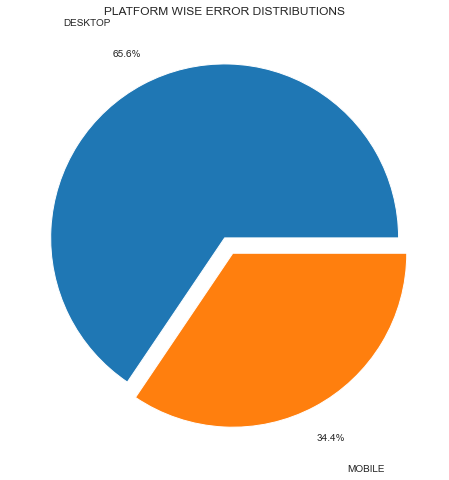

In [246]:
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
plot_pie_chart(column='PLATFORM',labels=['DESKTOP','MOBILE'],title='PLATFORM WISE ERROR DISTRIBUTIONS')

### Identifying where **the url has the problem**

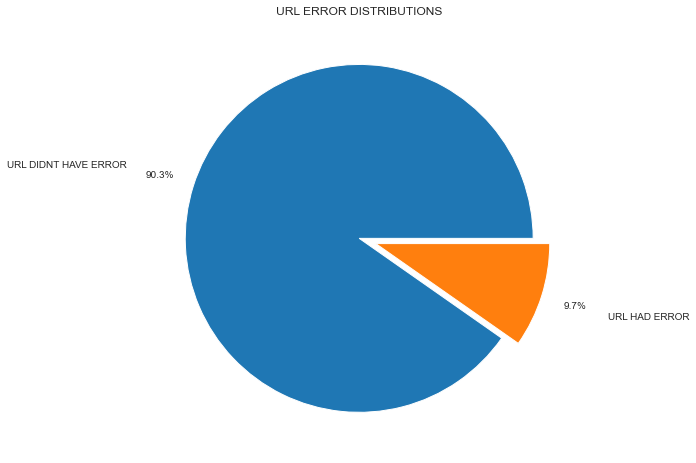

In [247]:
plot_pie_chart(column='IS_URL_ERROR',labels=['URL DIDNT HAVE ERROR','URL HAD ERROR'],title='URL ERROR DISTRIBUTIONS')


> Some examples where url was the problem

In [248]:
df['REQ_URL'][df['IS_URL_ERROR']].head(5)

3                                               https://eisamay.indiatimes.com/bangla-news-live/-/amp_articleshow/63640426.cms
39                                                              https://eisamay.indiatimes.com/videos/-/videoshow/19948537.cms
48                                    https://eisamay.indiatimes.com/bangla-news-live/-pti-pml-n-/amp_articleshow/65138004.cms
52                                                  https://eisamay.indiatimes.com/bangla-news-live/-/articleshow/66665445.cms
53    https://eisamay.indiatimes.com/astrology/dharma-karma/panchang/panchang-29-april-2016/-/panchanga/photoshow/52039176.cms
Name: REQ_URL, dtype: object

### Further categorizing the url  based  errors on  category of these urls and error types

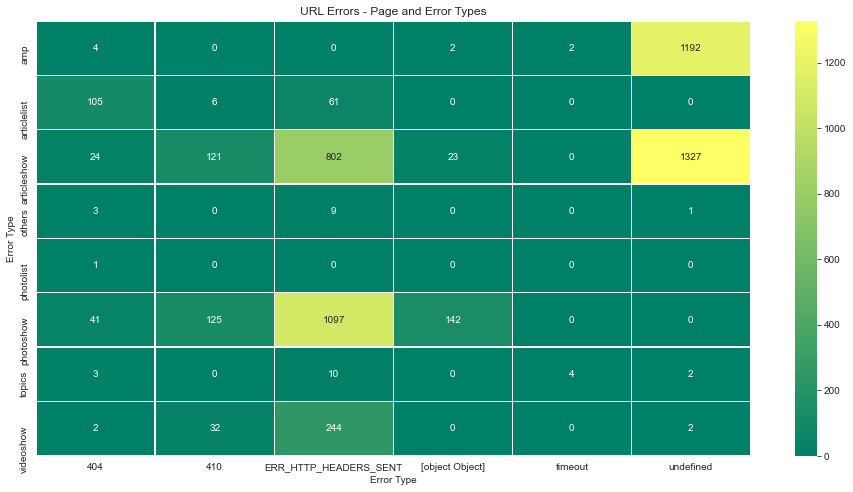

In [249]:
url_errors_grouped =  df[df['IS_URL_ERROR']].groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=url_errors_grouped,title='URL Errors - Page and Error Types',xlabel='Error Type',ylabel='Error Type',cmap='summer')


> Above heatmap contains all urls with errors, and error types on those urls

### Understanding about feed errors wherever they occur

In [250]:
## Seeing feed errors vs others
df[~(df['REQ_FEED'].isnull())].count()[0] / df.shape[0] 
# 41.8 percent feederrors 

0.5031858630710637

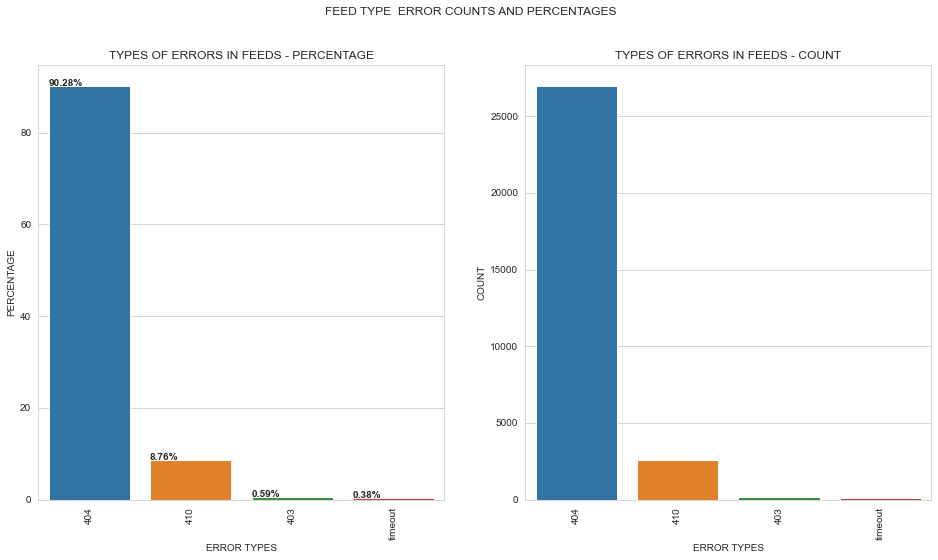

In [251]:
error_types_percentage_feeds = df[(df['ERROR_TYPE'] == '404') | (df['ERROR_TYPE'] == '410') | (df['ERROR_TYPE'] == '403') |  (df['ERROR_TYPE'] == 'timeout')] 

plot_percentage_and_count(df=error_types_percentage_feeds,column='ERROR_TYPE',xlabel="ERROR TYPES",title_count='TYPES OF ERRORS IN FEEDS - COUNT',title_percentage='TYPES OF ERRORS IN FEEDS - PERCENTAGE',supertitle='FEED TYPE  ERROR COUNTS AND PERCENTAGES')
# plot_pie_chart(percentage_dist=error_types_percentage_dist,labels=labels,title="FEED ERROR DISTRIBUTIONS")


> It seems that **majority of the feed errors are 404s**. However some feed errors are **410 and 403** respectively, which are surprising.

### Understanding distribution of errors on various templates

In [252]:
df['URL_CATEGORY'].value_counts()

articlelist    24940
articleshow    15010
amp             5779
videoshow       4815
photoshow       2330
others          1961
photolist        443
topics           123
Name: URL_CATEGORY, dtype: int64

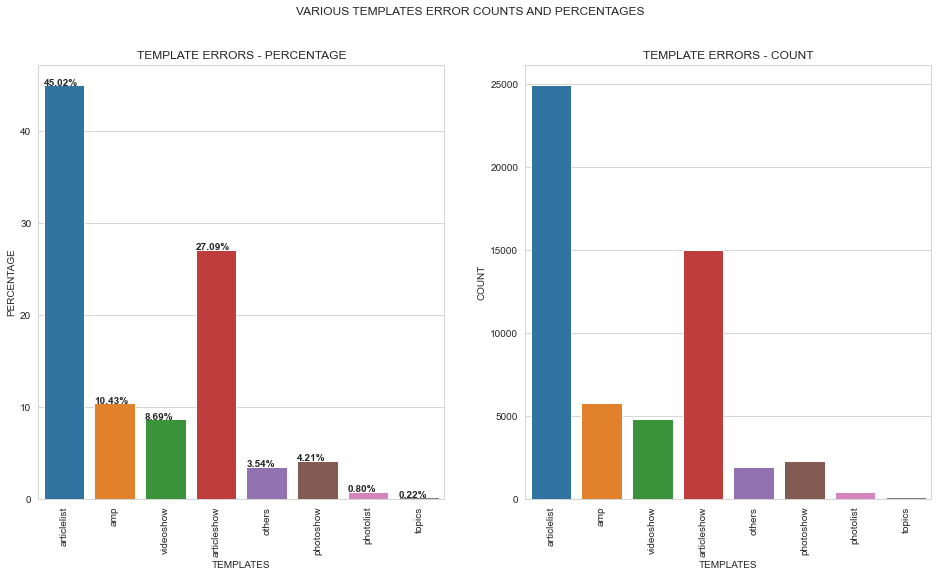

In [253]:
plot_percentage_and_count(column='URL_CATEGORY',xlabel="TEMPLATES",title_count='TEMPLATE ERRORS - COUNT',title_percentage='TEMPLATE ERRORS - PERCENTAGE',supertitle='VARIOUS TEMPLATES ERROR COUNTS AND PERCENTAGES')

> It seems that articlelist has the highest number of errors, followed by articleshow,amp and videoshow

### Understanding distribution of various error types

In [254]:
df['ERROR_TYPE'].value_counts()

404                      26996
ERR_HTTP_HEADERS_SENT    17928
undefined                 7203
410                       2618
[object Object]            353
403                        175
timeout                    113
other                       10
ECONNRESET                   5
Name: ERROR_TYPE, dtype: int64

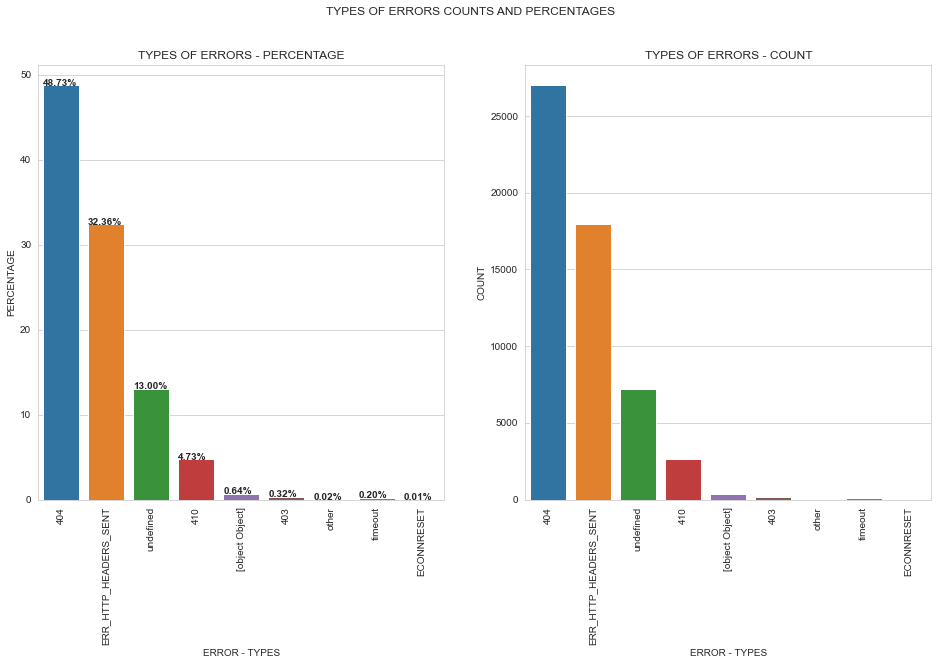

In [255]:
plot_percentage_and_count(column='ERROR_TYPE',xlabel="ERROR - TYPES",title_count='TYPES OF ERRORS - COUNT',title_percentage='TYPES OF ERRORS - PERCENTAGE',supertitle='TYPES OF ERRORS COUNTS AND PERCENTAGES')

### Error type vs pagetype heatmap

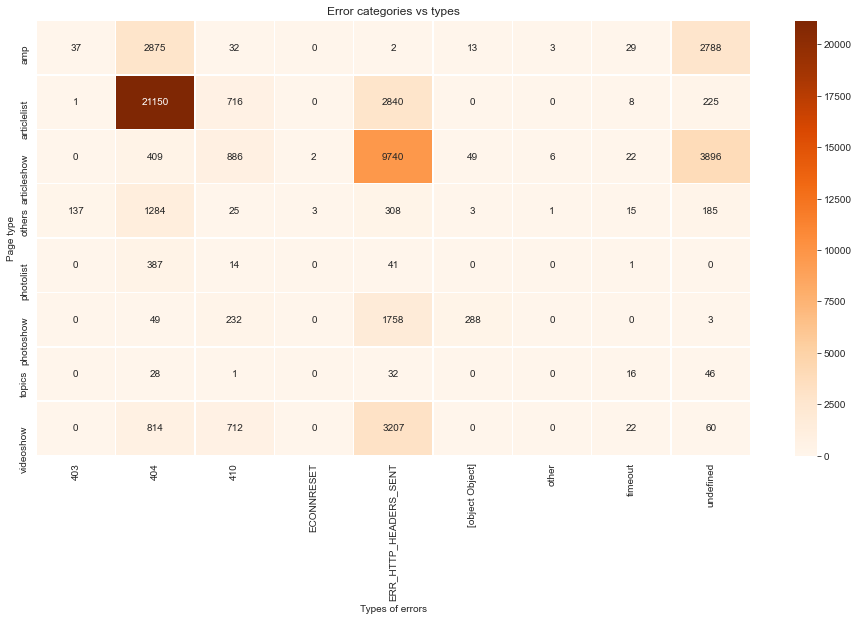

In [256]:
# Creating what type of templates have what type of errors
categories_vs_error_grouped =  df.groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=categories_vs_error_grouped,title='Error categories vs types',xlabel='Types of errors',ylabel='Page type',cmap='Oranges')

### Checking if time plays a factor in errors - Templates and Error Types


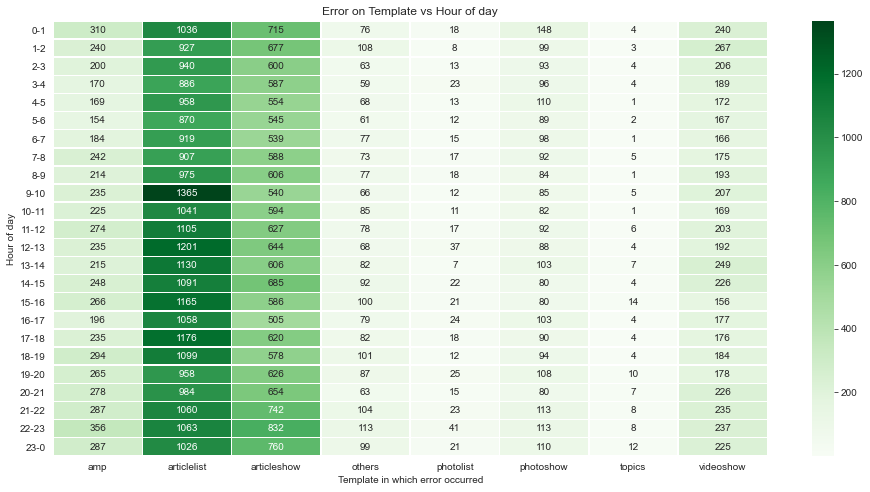

In [259]:
# Creating what type of templates have what type of errors

time_vs_url_category =  df.groupby(['BINNED_HOURS','URL_CATEGORY']).size().unstack(fill_value=0)

plot_heat_map(data=time_vs_url_category,title='Error on Template vs Hour of day',xlabel='Template in which error occurred',ylabel='Hour of day',cmap='Greens')

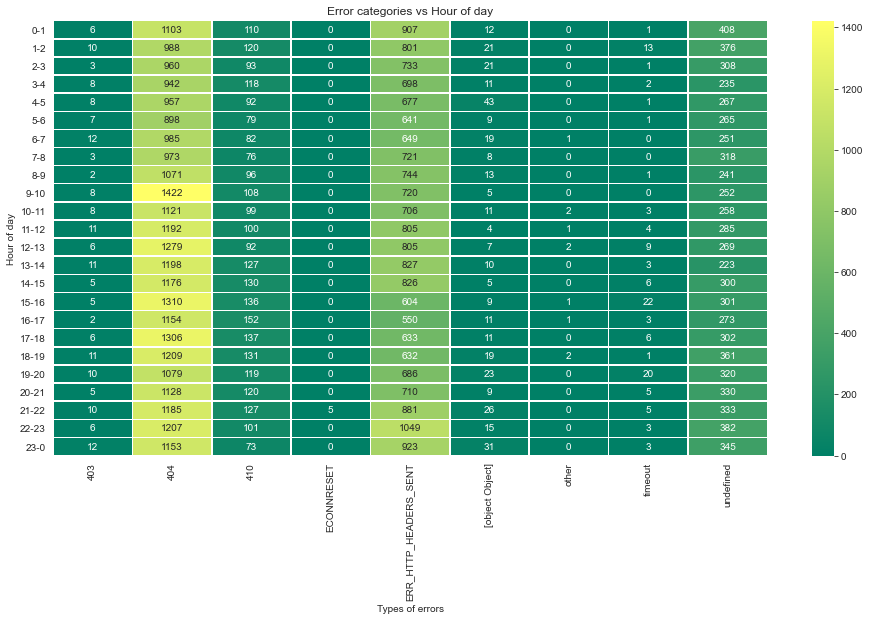

In [262]:
# Creating what type of templates have what type of errors
categories_vs_error_hour_of_day =  df.groupby(['BINNED_HOURS','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=categories_vs_error_hour_of_day,title='Error categories vs Hour of day',xlabel='Types of errors',ylabel='Hour of day',cmap='summer')

